In [1]:
import datetime
import time
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import ylim
from sklearn import neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int})
df = df.drop(['txid','bookingdate'], axis='columns')
df = df.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                   'bin':'issuer_id', 
                                   'shoppercountrycode':'shoppercountry', 
                                   'shopperinteraction':'interaction', 
                                   'cardverificationcodesupplied':'verification', 
                                   'cvcresponsecode':'cvcresponse', 
                                   'creationdate':'creationdate_stamp', 
                                   'simple_journal':'label'})

# Skip data if:
df = df[df['label']!='Refused']
df = df[~df['issuer_id'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

# Create and format (new) columns
df['creationdate'] = (pd.to_datetime(df['creationdate_stamp'])).dt.date
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)

df['label'] = df['label'].apply(lambda x: '1' if x == 'Chargeback' else '0')

converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}

def convert_to_usd(args):  # placeholder for your fancy conversion function
    amount, currency = args
    return converter[currency] * amount / 100

df['usd_amount'] = df[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

In [3]:
print("Total amount:", len(df))
fraud = df[df['label']=='1']
number_of_fraudulent_cases = len(fraud)
print("Number of fraudulent cases:", number_of_fraudulent_cases)
benign = df[df['label']=='0']
number_of_benign_cases = len(benign)
print("Number of benign cases:", number_of_benign_cases)

Total amount: 236698
Number of fraudulent cases: 345
Number of benign cases: 236353


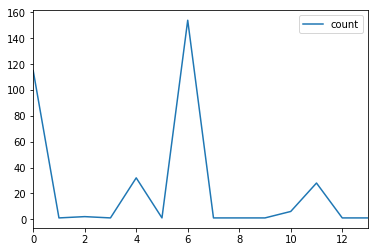

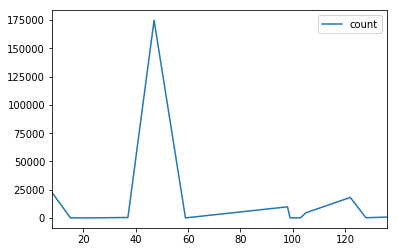

In [4]:
# The raw amount from the fraud/benign transactions per country were further processed in libre office to produce the graph.
amount_fraud_per_country = fraud.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
fraudulent_countries = list(amount_fraud_per_country['shoppercountry'])
amount_fraud_per_country.plot()

amount_benign_per_country = benign.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
amount_benign_per_country = amount_benign_per_country[pd.DataFrame(amount_benign_per_country.shoppercountry.tolist()).isin(fraudulent_countries).any(1)]
amount_benign_per_country.plot()

In [5]:
avg_usd_amount_fraud = statistics.mean(fraud['usd_amount'])
avg_usd_amount_benign = statistics.mean(benign['usd_amount'])
print("Average amount in USD for the fraudulent cases:", avg_usd_amount_fraud)
print("Average amount in USD for the benign cases:", avg_usd_amount_benign)

Average amount in USD for the fraudulent cases: 162.81484754202899
Average amount in USD for the benign cases: 87.06378282258909
